In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q transformers datasets nltk scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)
import nltk
from nltk.corpus import stopwords
from collections import Counter
import warnings
import os
import json

warnings.filterwarnings("ignore")
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [5]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')


In [6]:
# Load your dataset (update the path if needed)
df = pd.read_excel('/content/drive/MyDrive/Thesis/Dataset/10k_data _second.xlsx')
df.head()


,Label,Bengali,Banglish,English
0,sadness,আখেরি জামানা,akheri jamana,Last time
1,sadness,এটাই এখন নির্মম বাস্তবতা,etai ekhon nirmom bastobta,This is the harsh reality now
2,sadness,উক্ত ঘটনায় নিহত নাহিদের বাবার বিচার না পাওয়ার ...,ukto ghotnay nihot nahider babar Bichar na pao...,The fear of not getting justice for the father...
3,sadness,"নিউমার্কেট খুলে গেছে,, ঈদের পর ঢাকা কলেজও খুলে...","niumarket khule geche,, ider por dhaka kolejo ...","Newmarket has opened, Dhaka College will also ..."
4,sadness,আসল কথা বলব কি আমাদের বিএনপি'র মধ্যে মিল নেই য...,asol kotha bolob ki amader bnp'r moddhe mil ne...,"To tell the truth, do we have nothing in comm..."


In [7]:
# Download stopwords
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
try:
    stop_words_bn = set(stopwords.words('bengali'))
except:
    stop_words_bn = set()
stop_words_bl = stop_words_en.union({'ami','tumi','apni','amra','tomra','tara','se','ora','eta','eita','ota','oita','ki','koi','kemon','hoy','hobe','nai','na','to','tai','karon','jodi','je','ta','e','o','onek','kono','kichu','ekta','ekto','ektu','ekdom','sob','shob','pls','plz','vai','bhai'})

def clean_text(text, lang):
    if pd.isna(text): return ''
    text = str(text).strip()
    # remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^0-9A-Za-z\u0980-\u09FFA-Za-z\s]', ' ', text)  # keep Bengali + English chars
    text = re.sub(r'\s+', ' ', text).strip()

    # remove stopwords
    words = text.split()
    if lang=='English':
        words = [w for w in words if w.lower() not in stop_words_en]
    elif lang=='Bengali':
        words = [w for w in words if w not in stop_words_bn]
    elif lang=='Banglish':
        words = [w for w in words if w.lower() not in stop_words_bl]
    return " ".join(words)

for col in ['Bengali','Banglish','English']:
    df[col] = df[col].apply(lambda x: clean_text(x, col))

df['text_all'] = df[['Bengali','Banglish','English']].fillna('').agg(' '.join, axis=1).str.strip()
df = df[df['text_all'] != ''].reset_index(drop=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)
print("Labels:", label_names)


Labels: ['anger', 'fear', 'joy', 'sadness', 'surprise']


In [9]:
df_all_three = df[(df['Bengali'] != '') & (df['Banglish'] != '') & (df['English'] != '')].copy()
df_all_three['label_enc'] = le.transform(df_all_three['Label'])

train_df, test_df = train_test_split(df_all_three, test_size=0.2, stratify=df_all_three['label_enc'], random_state=42)

def create_dataset(df_sub, lang_col):
    return Dataset.from_dict({'text': df_sub[lang_col].tolist(), 'label': df_sub['label_enc'].tolist()})

ds_train_ben = create_dataset(train_df, 'Bengali')
ds_test_ben  = create_dataset(test_df,  'Bengali')

ds_train_bl = create_dataset(train_df, 'Banglish')
ds_test_bl  = create_dataset(test_df,  'Banglish')

ds_train_en = create_dataset(train_df, 'English')
ds_test_en  = create_dataset(test_df,  'English')
y_test = test_df['label_enc'].tolist()


In [10]:
def tokenize_dataset(ds, tokenizer, max_length=128):
    return ds.map(lambda batch: tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_length), batched=True)


In [15]:
def train_model(model_name, ds_train, ds_test, num_labels, epochs=1, batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

    ds_train_tok = tokenize_dataset(ds_train, tokenizer)
    ds_test_tok  = tokenize_dataset(ds_test, tokenizer)

    ds_train_tok.set_format('torch', columns=['input_ids','attention_mask','label'])
    ds_test_tok.set_format('torch', columns=['input_ids','attention_mask','label'])

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc}

    args = TrainingArguments(
        output_dir=f"/tmp/{model_name.replace('/', '_')}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none",
        load_best_model_at_end=False
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_tok,
        eval_dataset=ds_test_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Get predictions and probabilities
    preds_output = trainer.predict(ds_test_tok)
    probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=-1).numpy()

    # Extract per-epoch metrics from trainer.state.log_history
    history = {"epoch":[], "train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    for log in trainer.state.log_history:
        if 'epoch' in log:
            history["epoch"].append(log['epoch'])
            history["train_loss"].append(log.get('loss', None))
            history["val_loss"].append(log.get('eval_loss', None))
            history["train_acc"].append(log.get('train_accuracy', None))
            history["val_acc"].append(log.get('eval_accuracy', None))

    return model, tokenizer, probs, history


Training Bengali model...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8210 [00:00<?, ? examples/s]

Map:   0%|          | 0/2053 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.899100,0.678803,0.765222


Training Banglish model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8210 [00:00<?, ? examples/s]

Map:   0%|          | 0/2053 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.251400,1.022418,0.568924


Training English model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8210 [00:00<?, ? examples/s]

Map:   0%|          | 0/2053 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.917100,0.712494,0.737457


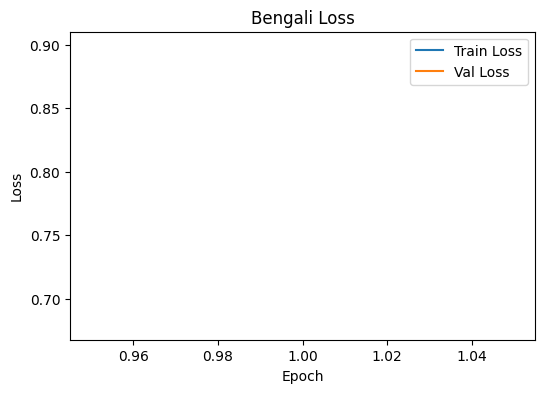

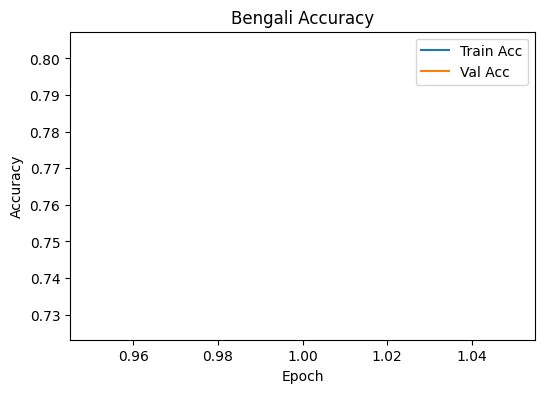

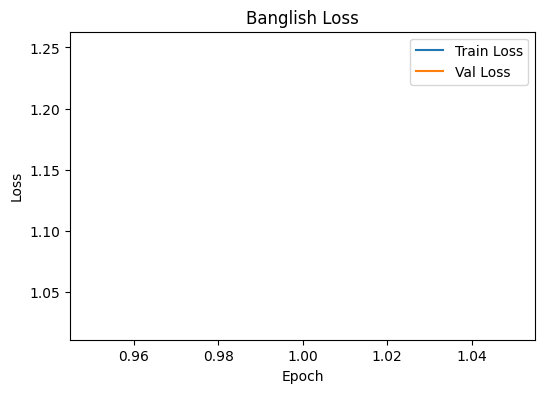

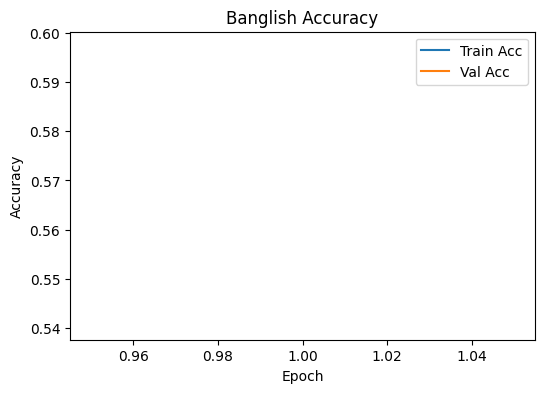

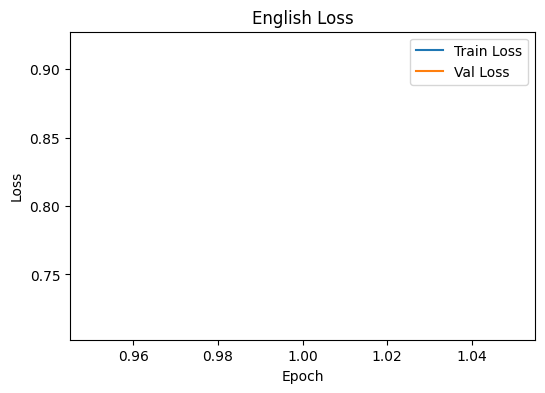

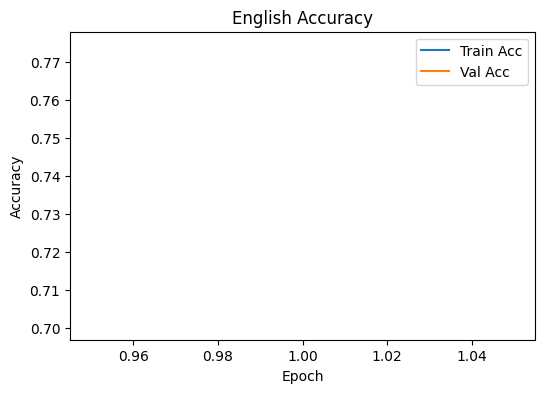

In [16]:
model_names = {
    "Bengali": "csebuetnlp/banglabert",
    "Banglish": "bert-base-multilingual-cased",
    "English": "bert-base-uncased"
}

print("Training Bengali model...")
model_ben, tok_ben, probs_ben, hist_ben = train_model(model_names["Bengali"], ds_train_ben, ds_test_ben, num_labels)

print("Training Banglish model...")
model_ban, tok_ban, probs_ban, hist_ban = train_model(model_names["Banglish"], ds_train_bl, ds_test_bl, num_labels)

print("Training English model...")
model_eng, tok_eng, probs_eng, hist_eng = train_model(model_names["English"], ds_train_en, ds_test_en, num_labels)


#Plot Training History
def plot_history(hist, lang):
    plt.figure(figsize=(6,4))
    plt.plot(hist["epoch"], hist["train_loss"], label="Train Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{lang} Loss"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["epoch"], hist["train_acc"], label="Train Acc")
    plt.plot(hist["epoch"], hist["val_acc"], label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{lang} Accuracy"); plt.legend(); plt.show()

plot_history(hist_ben, "Bengali")
plot_history(hist_ban, "Banglish")
plot_history(hist_eng, "English")



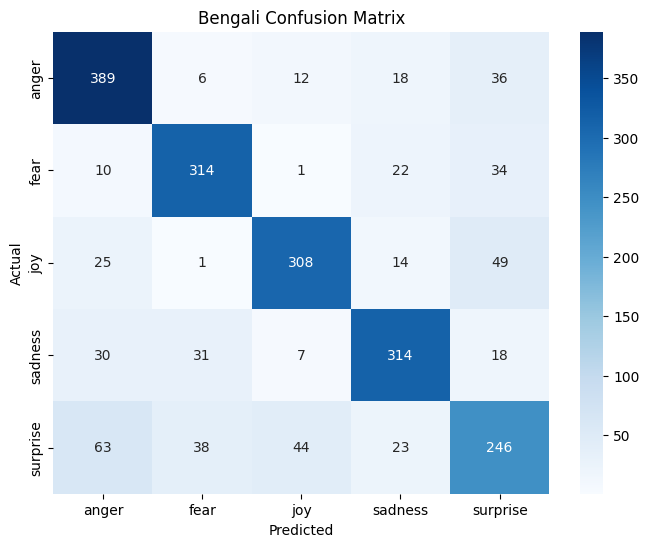

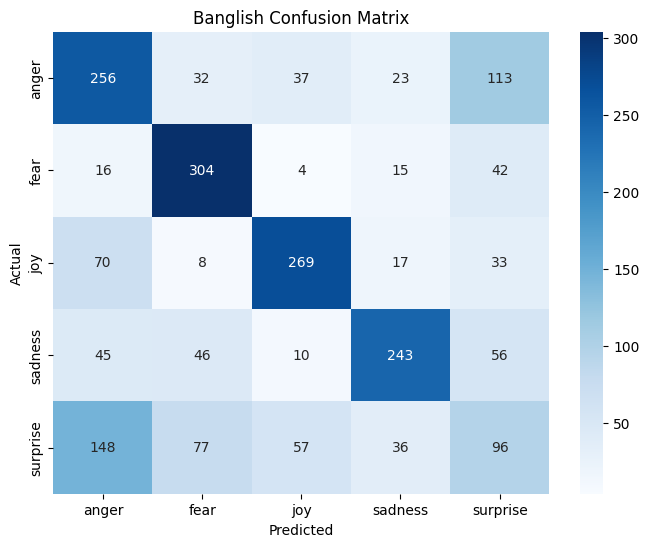

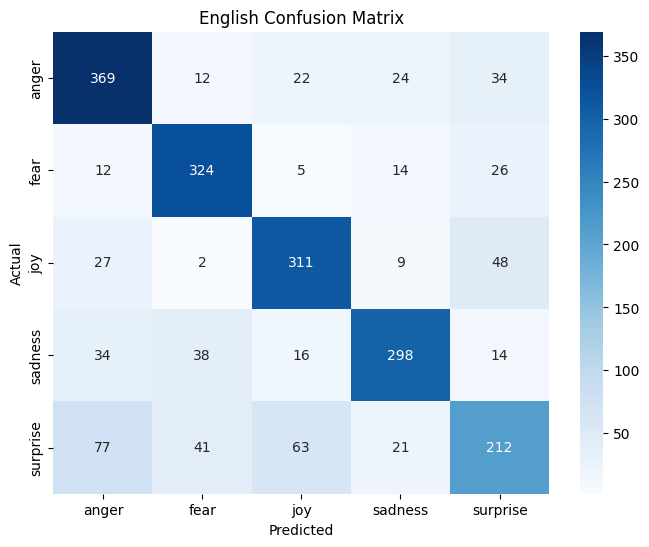

In [18]:
def plot_confusion(y_true, probs, label_names, lang):
    preds = np.argmax(probs, axis=1)
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.title(f"{lang} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, probs_ben, label_names, "Bengali")
plot_confusion(y_test, probs_ban, label_names, "Banglish")
plot_confusion(y_test, probs_eng, label_names, "English")


In [19]:
preds_ben = np.argmax(probs_ben, axis=1)
preds_ban = np.argmax(probs_ban, axis=1)
preds_eng = np.argmax(probs_eng, axis=1)

ensemble_preds = []
for b,a,e in zip(preds_ben, preds_ban, preds_eng):
    ensemble_preds.append(Counter([b,a,e]).most_common(1)[0][0])

ensemble_acc = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
print(classification_report(y_test, ensemble_preds, target_names=label_names))


Ensemble Accuracy: 0.7642
              precision    recall  f1-score   support

       anger       0.72      0.84      0.77       461
        fear       0.80      0.87      0.84       381
         joy       0.81      0.79      0.80       397
     sadness       0.84      0.77      0.80       400
    surprise       0.67      0.55      0.60       414

    accuracy                           0.76      2053
   macro avg       0.77      0.76      0.76      2053
weighted avg       0.76      0.76      0.76      2053



**Model Save**

In [20]:
model_filepath = '/content/drive/MyDrive/Thesis/Save Models'
os.makedirs(model_filepath, exist_ok=True)

for lang, model, tokenizer in zip(
    ["Bengali","Banglish","English"],
    [model_ben, model_ban, model_eng],
    [tok_ben, tok_ban, tok_eng]
):
    save_dir = os.path.join(model_filepath, f"{lang}_emotion_model")
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    with open(os.path.join(save_dir,"label_names.json"), "w", encoding="utf-8") as f:
        json.dump(label_names, f, ensure_ascii=False, indent=2)
print("Models saved!")


Models saved!


**Model Use**

In [23]:
# Load model for inference (example: Bengali)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import json

load_dir = '/content/drive/MyDrive/Thesis/Save Models/Bengali_emotion_model'
tokenizer = AutoTokenizer.from_pretrained(load_dir)
model = AutoModelForSequenceClassification.from_pretrained(load_dir).to(device)
with open(f"{load_dir}/label_names.json","r",encoding="utf-8") as f:
    label_names = json.load(f)

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]
        pred = np.argmax(probs)
    return label_names[pred], probs

# Example usage
user_input = input("Enter a sentence (type 'exit' to stop): ")
if user_input.lower() != 'exit':
    pred_label, pred_probs = predict(user_input)
    print("Predicted Emotion:", pred_label)
    print("Probabilities:", pred_probs)


Enter a sentence (type 'exit' to stop): আমার প্রিয় খেলা হেরে যাওয়ায় মন খারাপ, এত চেষ্টা করেও সাফল্য আসেনি।


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Emotion: sadness
Probabilities: [0.04769897 0.02935772 0.01163539 0.88189703 0.02941087]


In [26]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from langdetect import detect
import json

class EmotionEnsemble:
    def __init__(self, models_info):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.models = {}
        self.tokenizers = {}
        self.label_names = {}

        for lang, path in models_info.items():
            self.tokenizers[lang] = AutoTokenizer.from_pretrained(path)
            self.models[lang] = AutoModelForSequenceClassification.from_pretrained(path).to(self.device)
            with open(f"{path}/label_names.json", "r", encoding="utf-8") as f:
                self.label_names[lang] = json.load(f)

    def detect_language(self, text):
        try:
            lang_code = detect(text)
            if lang_code == "bn":
                return "Bengali"
            elif lang_code == "en":
                return "English"
            else:
                return "Banglish"
        except:
            return "Banglish"

    def predict(self, text):
        lang = self.detect_language(text)
        tokenizer = self.tokenizers[lang]
        model = self.models[lang]
        labels = self.label_names[lang]

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]
            pred = np.argmax(probs)
        return labels[pred], probs, lang


In [27]:
import pickle

ensemble = EmotionEnsemble(models_info)

# Save wrapper object
with open("/content/drive/MyDrive/Thesis/Save Models/ensemble_wrapper.pkl", "wb") as f:
    pickle.dump(ensemble, f)


In [ ]:
import pickle

# Load ensemble
with open("/content/drive/MyDrive/Thesis/Save Models/ensemble_wrapper.pkl", "rb") as f:
    ensemble = pickle.load(f)

print("Enter your text to detect emotion. Type 'quit' to exit.")

while True:
    user_input = input("\nYour text: ")
    if user_input.lower() == "quit":
        print("Exiting...")
        break

    pred_label, pred_probs, lang = ensemble.predict(user_input)
    print(f"Detected Language: {lang}")
    print(f"Predicted Emotion: {pred_label}")
    print(f"Probabilities: {pred_probs}")


Enter your text to detect emotion. Type 'quit' to exit.

Your text: বন্ধুদের সঙ্গে আজকের বিকেলের খোলা আড্ডা মনে রাখার মতো আনন্দদায়ক হয়েছে, আমি সত্যিই মজা পেয়েছি।


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Detected Language: Bengali
Predicted Emotion: joy
Probabilities: [0.02624603 0.01500985 0.8359148  0.02727468 0.09555463]

Your text: আগামীকালকার পরীক্ষায় আমি প্রস্তুত নই, ভাবতেই ভয় লাগে যে ফলাফল খারাপ হতে পারে।
Detected Language: Bengali
Predicted Emotion: fear
Probabilities: [0.00910188 0.9161152  0.00488332 0.0363318  0.03356777]

Your text: হঠাৎ বন্ধু এসে আমাকে বড় খবরটি জানালো, বিশ্বাস করতে পারলাম না আমি।
Detected Language: Bengali
Predicted Emotion: surprise
Probabilities: [0.0438838  0.06702425 0.03876324 0.03781821 0.81251043]

Your text: আজকের পরীক্ষার ফলাফল দেখে মনে হলো, এত পরিশ্রম করার পরও আমার চেষ্টা বৃথা গেছে, সত্যিই হতাশ লাগছে।
Detected Language: Bengali
Predicted Emotion: fear
Probabilities: [0.02516315 0.62095904 0.00803443 0.2827002  0.06314315]

Your text: Jokhon shobai amar kotha ignore kore nijer moto kaj kore, tokhon ami khub upset hoye jai.
Detected Language: Banglish
Predicted Emotion: sadness
Probabilities: [0.01709726 0.02058861 0.01355338 0.9194569  0.029303